#### Generate predictions for a new list of chemicals for Fraction Unbound


- Step 1: Identify substances of interest and their SMILES codes - Use KNIME to convert SMILES into a V2000 sdf file
- See KNIME workflow presented in models directory (httk/models) for example knwf file generated in KNIME 3.7.2
- Step 2: Use sdf file to generate Pubchem and ToxPrint Fingerprints using KNIME and the Chemotyper
- Step 3: Use sdf file to generate OPERA descriptors (v2.6)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
import glob

In [2]:
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import r2_score
import pickle

In [3]:
def normalizeDescriptors(X):
    scaler = preprocessing.StandardScaler().fit(X)
    transformed = scaler.transform(X)
    x_norm = pd.DataFrame(transformed, index = X.index) 
    x_norm.columns = X.columns
    return(x_norm)

In [4]:
raw_dir = '/home/grace/Documents/python/httk/data/raw/'
processed_dir = '/home/grace/Documents/python/httk/data/processed/'
interim_dir = '/home/grace/Documents/python/httk/data/interim/'
figures_dir = '/home/grace/Documents/python/httk/reports/figures/'
external_dir = '/home/grace/Documents/python/httk/data/external/'
models_dir = '/home/grace/Documents/python/httk/models/'

Importing descriptor files

In [5]:
pubchem = pd.read_csv(processed_dir+'Fub_Pubchem.csv')

In [6]:
pubchem.head()

,CASRN,bitvector0,bitvector1,bitvector2,bitvector3,bitvector4,bitvector5,bitvector6,bitvector7,bitvector8,...,bitvector871,bitvector872,bitvector873,bitvector874,bitvector875,bitvector876,bitvector877,bitvector878,bitvector879,bitvector880
0,94-74-6,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,148477-71-8,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,56-29-1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,153233-91-1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,96182-53-5,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
pubchem.shape

(1120, 882)

In [8]:
pubchem.CASRN.value_counts().sort_values(ascending = False)

106-46-7       1
838-88-0       1
5234-68-4      1
98967-40-9     1
19794-93-5     1
              ..
29122-68-7     1
102625-70-7    1
122-39-4       1
79350-37-1     1
533-45-9       1
Name: CASRN, Length: 1120, dtype: int64

In [9]:
pubchem.set_index('CASRN', inplace = True)

In [10]:
cdk = pd.read_csv(processed_dir+'Fub_CDK.csv')

In [11]:
cdk.head()

,Molecule,INPUT,FOUND_BY,DTXSID,PREFERRED_NAME,CASRN,Molecular Weight,SMILES,QSAR_READY_SMILES,Mannhold LogP,...,XLogP,Zagreb Index,Molecular Formula,Formal Charge,Formal Charge (pos),Formal Charge (neg),Heavy Atoms Count,Molar Mass,SP3 Character,Rotatable Bonds Count (non terminal)
0,Cc1c(OCC(O)=O)ccc(Cl)c1,94-74-6,CAS-RN,DTXSID4024195,MCPA,94-74-6,200.024022,CC1=C(OCC(O)=O)C=CC(Cl)=C1,CC1=C(OCC(O)=O)C=CC(Cl)=C1,2.01,...,2.167,60,C9H9ClO3,0,0,0,13,200.619242,0.090909,3
1,CCC(C)(C)C(=O)OC1=C(C(=O)OC21CCCCC2)c3ccc(Cl)c...,148477-71-8,CAS-RN,DTXSID6034928,Spirodiclofen,148477-71-8,410.105165,CCC(C)(C)C(=O)OC1=C(C(=O)OC11CCCCC1)C1=CC=C(Cl...,CCC(C)(C)C(=O)OC1=C(C(=O)OC11CCCCC1)C1=CC=C(Cl...,3.11,...,6.084,146,C21H24Cl2O4,0,0,0,27,411.319527,0.215686,5
2,CN1C(O)=NC(=O)C(C)(C2=CCCCC2)C1=O,56-29-1,CAS-RN,DTXSID9023122,Hexobarbital,56-29-1,236.116092,CN1C(O)=NC(=O)C(C)(C2=CCCCC2)C1=O,CN1C(O)=NC(=O)C(C)(C2=CCCCC2)C1=O,2.23,...,1.838,90,C12H16N2O3,0,0,0,17,236.267504,0.212121,1
3,CCOc1c(ccc(c1)C(C)(C)C)C2COC(=N2)c3c(F)cccc3F,153233-91-1,CAS-RN,DTXSID8034586,Etoxazole,153233-91-1,359.169685,CCOC1=C(C=CC(=C1)C(C)(C)C)C1COC(=N1)C1=C(F)C=C...,CCOC1=C(C=CC(=C1)C(C)(C)C)C1COC(=N1)C1=C(F)C=C...,3.22,...,6.008,138,C21H23F2NO2,0,0,0,26,359.410411,0.163265,5
4,CCOP(=S)(OC(C)C)Oc1cnc(nc1)C(C)(C)C,96182-53-5,CAS-RN,DTXSID1032482,Tebupirimfos,96182-53-5,318.116700,CCOP(=S)(OC(C)C)OC1=CN=C(N=C1)C(C)(C)C,CCOP(=S)(OC(C)C)OC1=CN=C(N=C1)C(C)(C)C,2.12,...,3.253,98,C13H23N2O3PS,0,0,0,20,318.373672,0.209302,7


Does not look like CDK descriptors are included in the Fub model

In [12]:
txps = pd.read_excel(processed_dir+'ToxPrints.xlsx')

In [13]:
txps.head()

,INPUT,DTXSID,PREFERRED_NAME,atom:element_main_group,atom:element_metal_group_I_II,atom:element_metal_group_III,atom:element_metal_metalloid,atom:element_metal_poor_metal,atom:element_metal_transistion_metal,atom:element_noble_gas,...,ring:polycycle_bicyclo_propene,ring:polycycle_spiro_[2.2]pentane,ring:polycycle_spiro_[2.5]octane,ring:polycycle_spiro_[4.5]decane,ring:polycycle_spiro_1_4-dioxaspiro[4.5]decane,ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene,ring:polycycle_tricyclo_[3.7.7]bullvalene,ring:polycycle_tricyclo_[3.7.7]semibullvalene,ring:polycycle_tricyclo_adamantane,ring:polycycle_tricyclo_benzvalene
0,94-74-6,DTXSID4024195,MCPA,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,148477-71-8,DTXSID6034928,Spirodiclofen,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,56-29-1,DTXSID9023122,Hexobarbital,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,153233-91-1,DTXSID8034586,Etoxazole,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,96182-53-5,DTXSID1032482,Tebupirimfos,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
txps.INPUT.value_counts().sort_values(ascending = False)

106-46-7       1
5543-58-8      1
42399-41-7     1
60-57-1        1
83881-51-0     1
              ..
208-96-8       1
29122-68-7     1
102625-70-7    1
5152-30-7      1
533-45-9       1
Name: INPUT, Length: 1139, dtype: int64

In [15]:
txps.set_index('INPUT', inplace = True)

txps.drop(['DTXSID', 'PREFERRED_NAME'], axis = 1, inplace = True)
txps.head()

,atom:element_main_group,atom:element_metal_group_I_II,atom:element_metal_group_III,atom:element_metal_metalloid,atom:element_metal_poor_metal,atom:element_metal_transistion_metal,atom:element_noble_gas,bond:C#N_cyano_acylcyanide,bond:C#N_cyano_cyanamide,bond:C#N_cyano_cyanohydrin,...,ring:polycycle_bicyclo_propene,ring:polycycle_spiro_[2.2]pentane,ring:polycycle_spiro_[2.5]octane,ring:polycycle_spiro_[4.5]decane,ring:polycycle_spiro_1_4-dioxaspiro[4.5]decane,ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene,ring:polycycle_tricyclo_[3.7.7]bullvalene,ring:polycycle_tricyclo_[3.7.7]semibullvalene,ring:polycycle_tricyclo_adamantane,ring:polycycle_tricyclo_benzvalene
INPUT,,,,,,,,,,,,,,,,,,,,,
94-74-6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
148477-71-8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
56-29-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
153233-91-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96182-53-5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df_opera = pd.read_csv(processed_dir+'Fub-sdf_OPERA2.6Pred.csv', index_col='CASRN')[['LogP_pred','pKa_a_pred', 'pKa_b_pred']] #In MOE: Right click on mol -> Name -> Extract -> new field 'CAS'
df_opera['pKa_pred']=df_opera[['pKa_a_pred','pKa_b_pred']].min(axis=1)
df_opera = df_opera[~df_opera.index.duplicated(keep='first')]


In [20]:
opera_scaler = pickle.load(open(models_dir+'opera_scaler_v2.sav', 'rb'))

In [21]:
# Normalize opera properties based on transformation scaler vector from the base models
opera_scaled = opera_scaler.transform(df_opera)
opera = pd.DataFrame(opera_scaled, index = df_opera.index) 
opera.columns = df_opera.columns
opera = opera[['pKa_pred','LogP_pred']]

New supplementary file to the Fub final features as described in Human.Funbound.plasma_Features_v2

In [22]:
desc = pd.read_csv(external_dir+'Human.Funbound.plasma_Features_v2.csv') 

#### Note txps_ and pubchem_ descriptors set have different dimensions in terms of what could be calculated. Need either to merge the sets by an inner join or take the set of common ids and concatenate the dfs together. Here we take the common CASRN ids and concat the 2 df by column using axis = 1

In [23]:
ids = list(set(pubchem.index & txps.index))

In [24]:
txps = txps.loc[ids]

In [25]:
pubchem = pubchem.loc[ids]

In [26]:
fingerprints = pd.concat([pubchem,txps ], axis =1)

In [27]:
fingerprints

,bitvector0,bitvector1,bitvector2,bitvector3,bitvector4,bitvector5,bitvector6,bitvector7,bitvector8,bitvector9,...,ring:polycycle_bicyclo_propene,ring:polycycle_spiro_[2.2]pentane,ring:polycycle_spiro_[2.5]octane,ring:polycycle_spiro_[4.5]decane,ring:polycycle_spiro_1_4-dioxaspiro[4.5]decane,ring:polycycle_tricyclo_[3.5.5]_cyclopropa[cd]pentalene,ring:polycycle_tricyclo_[3.7.7]bullvalene,ring:polycycle_tricyclo_[3.7.7]semibullvalene,ring:polycycle_tricyclo_adamantane,ring:polycycle_tricyclo_benzvalene
83881-51-0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1702-17-6,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
84625-61-6,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
137862-53-4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5543-58-8,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127779-20-8,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2008-41-5,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
57-83-0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1610-18-0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# Select fingerprints from the feature file
retain = [str(val.replace("'", "").replace(" ", "")) for val in desc.loc[0,'Fingerprints'].split(',')]
retain[0] = retain[0].replace("[", "")
retain[len(retain)-1] = retain[len(retain)-1].replace("c]",'c')
fingerprints_fub = fingerprints.loc[:,retain]

In [29]:
fingerprints_fub = fingerprints.loc[:,retain]

In [30]:
fingerprints_fub.head()

,bitvector2,bitvector12,bitvector15,bitvector16,bitvector19,bitvector20,bitvector33,bitvector37,bitvector143,bitvector145,...,bitvector712,bond:CN_amine_aliphatic_generic,bond:CN_amine_ter-N_aliphatic,bond:COH_alcohol_generic,bond:CX_halide_aromatic-X_generic,chain:alkaneCyclic_ethyl_C2_(connect_noZ),chain:alkaneLinear_ethyl_C2(H_gt_1),chain:alkaneLinear_ethyl_C2_(connect_noZ_CN=4),chain:aromaticAlkane_Ph-C1_acyclic_connect_noDblBd,ring:hetero_[6]_N_pyridine_generic
83881-51-0,1,1,1,0,1,0,0,1,0,0,...,0,1,1,0,1,0,1,0,1,0
1702-17-6,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
84625-61-6,1,1,1,1,1,1,0,1,1,1,...,0,0,1,0,1,0,1,1,0,0
137862-53-4,1,1,1,1,1,0,0,0,1,1,...,1,0,0,0,0,0,1,1,1,0
5543-58-8,1,1,0,0,1,1,0,0,0,0,...,1,0,0,1,0,0,0,1,1,0


In [31]:
padel = pd.read_csv(processed_dir+'padel.csv', index_col = 'Name')

/home/grace/anaconda3/envs/httk/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (67,68,69,70,71,72,73,74,75,121,122,123,124,125,126,127,128,129,785,786,831,834,850,851,904,905,950,953,969,970,1140,1141,1145,1147,1150) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
padel.head()

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
Name,,,,,,,,,,,,,,,,,,,,,
94-74-6,1,0.7906,0.625048,24.5181,26.427137,6,6,22,13,9,...,9.092001,25.243848,1.941834,10.285051,7.771488,0.000000,266.0,15.0,1.942,60.0
148477-71-8,0,1.7152,2.941911,76.1574,60.531032,6,6,51,27,24,...,8.041278,54.160760,2.005954,16.368275,11.293233,0.000000,1661.0,48.0,5.468,146.0
56-29-1,0,-0.5790,0.335241,58.7187,36.394688,0,0,33,17,16,...,7.155033,33.720604,1.983565,13.671018,7.544963,6.126055,458.0,32.0,1.838,90.0
153233-91-1,0,2.6304,6.919004,48.0469,56.114239,12,12,49,26,23,...,7.329994,52.376492,2.014480,14.332016,6.073529,3.156631,1688.0,42.0,6.844,138.0
96182-53-5,0,2.7615,7.625882,63.3122,49.352239,6,6,43,20,23,...,7.398063,38.619132,1.930957,21.024075,8.841324,6.106695,871.0,27.0,4.154,98.0


In [33]:
padel_ = padel[['nN', 'nO', 'nS', 'nP', 'nF', 'nCl', 'nBr', 'nI', 'SM1_DzZ', 'SM1_Dzv']]

In [34]:
padel_ = normalizeDescriptors(padel_)

/home/grace/anaconda3/envs/httk/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/grace/anaconda3/envs/httk/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [35]:
padel_ = padel_.loc[ids]

Turns out no Padel descriptors are needed despite what is written in Table S6 and captured in MMC24 since the Fub model only needs 82 descriptors and addition of Padel descriptors results in their being 92!

In [36]:
opera_ = opera.loc[ids]

In [37]:
opera_.head()

,pKa_pred,LogP_pred
CASRN,,
83881-51-0,-0.793261,-0.405075
1702-17-6,-1.708835,-0.734411
84625-61-6,0.414757,1.629032
137862-53-4,-0.858263,-0.812083
5543-58-8,0.398053,0.266797


In [38]:
descriptors = pd.concat([fingerprints_fub, opera_], axis=1).dropna(axis=0, how='any')

In [39]:
descriptors

,bitvector2,bitvector12,bitvector15,bitvector16,bitvector19,bitvector20,bitvector33,bitvector37,bitvector143,bitvector145,...,bond:CN_amine_ter-N_aliphatic,bond:COH_alcohol_generic,bond:CX_halide_aromatic-X_generic,chain:alkaneCyclic_ethyl_C2_(connect_noZ),chain:alkaneLinear_ethyl_C2(H_gt_1),chain:alkaneLinear_ethyl_C2_(connect_noZ_CN=4),chain:aromaticAlkane_Ph-C1_acyclic_connect_noDblBd,ring:hetero_[6]_N_pyridine_generic,pKa_pred,LogP_pred
CASRN,,,,,,,,,,,,,,,,,,,,,
83881-51-0,1,1,1,0,1,0,0,1,0,0,...,1,0,1,0,1,0,1,0,-0.793261,-0.405075
1702-17-6,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,1,-1.708835,-0.734411
84625-61-6,1,1,1,1,1,1,0,1,1,1,...,1,0,1,0,1,1,0,0,0.414757,1.629032
137862-53-4,1,1,1,1,1,0,0,0,1,1,...,0,0,0,0,1,1,1,0,-0.858263,-0.812083
5543-58-8,1,1,0,0,1,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0.398053,0.266797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1949-45-7,0,0,1,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,-0.871964,-0.691629
127779-20-8,1,1,1,1,1,1,0,0,0,0,...,1,1,0,1,0,0,1,1,0.531678,1.134737
2008-41-5,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,1,0,0,-0.798712,0.852100


#### Load sklearn pickle files

In [40]:
fub_rf = pickle.load(open(models_dir+'fub_rf_v2.sav', 'rb'))
fub_svr = pickle.load(open(models_dir+'fub_svr_v2.sav', 'rb'))

Number of features in the saved model for random forest

In [41]:
len(fub_rf.feature_importances_)


82

In [42]:
descriptors.shape

(992, 82)

Make predictions of the substances using the RF model

In [43]:
predicted_Fub = pd.DataFrame(1/(1+10**fub_rf.predict(descriptors)), descriptors.index )

In [44]:
predicted_Fub.columns = ['pred_Fub_rf']

In [45]:
predicted_Fub_2 = pd.DataFrame(1/(1+10**fub_svr.predict(descriptors)), descriptors.index )

In [46]:
predicted_Fub_2.columns = ['pred_Fub_svr']

In [47]:
predicted_Fub_all = pd.concat([predicted_Fub, predicted_Fub_2], axis = 1)

In [48]:
predicted_Fub_all['Consensus (SVM,RF)'] = predicted_Fub_all[['pred_Fub_svr', 'pred_Fub_rf']].mean(axis = 1)

In [49]:
predicted_Fub_all[predicted_Fub_all.index == '1007-28-9']

,pred_Fub_rf,pred_Fub_svr,"Consensus (SVM,RF)"
CASRN,,,
1007-28-9,0.553068,0.516319,0.534694


#### Comparing against the training set compounds - MMC2 in Supplementary corresponds to Fub_1139.csv here

Note that can't check whether the predictions are exact matches given we only have one of the predictions and no predicted file to check

In [50]:
fub = pd.read_csv(raw_dir+'Fub_1139.csv')

In [51]:
fub_expt = fub[fub['CASRN'].isin(predicted_Fub_all.index)]

In [52]:
fub_expt.set_index('CASRN', inplace = True)

In [53]:
fub_expt.loc[predicted_Fub_all.index]

,Name,Human.Funbound.plasma
CASRN,,
83881-51-0,Cetirizine,0.010000
1702-17-6,Clopyralid,0.438084
84625-61-6,Itraconazole,0.002000
137862-53-4,Valsartan,0.040000
5543-58-8,R-warfarin|(r)-warfarin,0.023000
...,...,...
1949-45-7,Metrizoate|Metrizoic acid,1.000000
127779-20-8,Saquinavir,0.028000
2008-41-5,Butylate,0.000000


In [54]:
fub_expt[fub_expt.index == '1007-28-9']

,Name,Human.Funbound.plasma
CASRN,,
1007-28-9,6-desisopropylatrazine|Deisopropylatrazine,0.459


Exploring the predictions from OPERA between versions 2.4 and 2.6

In [55]:
df_opera2 = pd.read_csv(processed_dir+'OPERA2.4_Pred.csv', index_col='MoleculeID')[['LogP_pred','pKa_a_pred', 'pKa_b_pred']] #In MOE: Right click on mol -> Name -> Extract -> new field 'CAS'
df_opera2['pKa_pred']=df_opera2[['pKa_a_pred','pKa_b_pred']].min(axis=1)
df_opera2 = df_opera2[~df_opera2.index.duplicated(keep='first')]


In [56]:
opera_scaled2 = opera_scaler.transform(df_opera2)
opera_2 = pd.DataFrame(opera_scaled2, index = df_opera2.index) 
opera_2.columns = df_opera2.columns
opera_2 = opera_2[['pKa_pred','LogP_pred']]

In [57]:
opera_2
opera_2a = opera_2.loc[ids]

In [58]:
opera_2a

,pKa_pred,LogP_pred
MoleculeID,,
83881-51-0,-0.793261,-0.283408
1702-17-6,NaN,-0.667372
84625-61-6,0.414757,1.646863
137862-53-4,-0.858263,-0.208011
5543-58-8,0.398053,0.139268
...,...,...
127779-20-8,0.531678,1.030108
2008-41-5,-0.798712,0.801955
57-83-0,NaN,0.740991


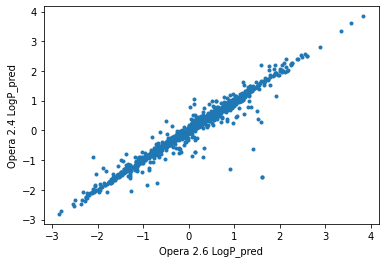

In [59]:
plt.plot( opera_['LogP_pred'], opera_2a['LogP_pred'], marker = '.', linestyle = 'none')
plt.xlabel('Opera 2.6 LogP_pred')
plt.ylabel('Opera 2.4 LogP_pred');

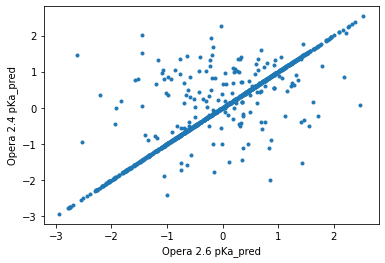

In [60]:
plt.plot( opera_['pKa_pred'], opera_2a['pKa_pred'], marker = '.', linestyle = 'none')
plt.xlabel('Opera 2.6 pKa_pred')
plt.ylabel('Opera 2.4 pKa_pred');

In [61]:
descriptors_2 = pd.concat([fingerprints_fub, opera_2a], axis=1).dropna(axis=0, how='any')

In [63]:
descriptors_2.head()

,bitvector2,bitvector12,bitvector15,bitvector16,bitvector19,bitvector20,bitvector33,bitvector37,bitvector143,bitvector145,...,bond:CN_amine_ter-N_aliphatic,bond:COH_alcohol_generic,bond:CX_halide_aromatic-X_generic,chain:alkaneCyclic_ethyl_C2_(connect_noZ),chain:alkaneLinear_ethyl_C2(H_gt_1),chain:alkaneLinear_ethyl_C2_(connect_noZ_CN=4),chain:aromaticAlkane_Ph-C1_acyclic_connect_noDblBd,ring:hetero_[6]_N_pyridine_generic,pKa_pred,LogP_pred
MoleculeID,,,,,,,,,,,,,,,,,,,,,
83881-51-0,1,1,1,0,1,0,0,1,0,0,...,1,0,1,0,1,0,1,0,-0.793261,-0.283408
84625-61-6,1,1,1,1,1,1,0,1,1,1,...,1,0,1,0,1,1,0,0,0.414757,1.646863
137862-53-4,1,1,1,1,1,0,0,0,1,1,...,0,0,0,0,1,1,1,0,-0.858263,-0.208011
5543-58-8,1,1,0,0,1,1,0,0,0,0,...,0,1,0,0,0,1,1,0,0.398053,0.139268
122836-35-5,0,0,1,1,1,0,1,1,1,1,...,0,0,1,0,0,0,0,0,-0.755394,-0.601741


In [64]:
predicted_Fub1 = pd.DataFrame(1/(1+10**fub_rf.predict(descriptors_2)), descriptors_2.index )
predicted_Fub1.columns = ['pred_Fub_rf']
predicted_Fub3 = pd.DataFrame(1/(1+10**fub_svr.predict(descriptors_2)), descriptors_2.index )
predicted_Fub3.columns = ['pred_Fub_svr']
predicted_Fub_all_1 = pd.concat([predicted_Fub1, predicted_Fub3], axis = 1)
predicted_Fub_all_1['Consensus (SVM,RF)'] = predicted_Fub_all_1[['pred_Fub_svr', 'pred_Fub_rf']].mean(axis = 1)

In [65]:
predicted_Fub_all_1[predicted_Fub_all_1.index == '1007-28-9']

,pred_Fub_rf,pred_Fub_svr,"Consensus (SVM,RF)"
MoleculeID,,,
1007-28-9,0.523258,0.481553,0.502406
